# Plotting the charts presented in the paper

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
import util
from model.sirds_model_visualization import get_sirds, get_sirds_extras, plot_result_simple

## Loading data

In [2]:
list_bottom_3_outliers = ['Feira de Santana/BA', 'São Luís/MA', 'Florianópolis/SC']
list_top_3_outliers = ['Cuiabá/MT', 'Rio de Janeiro/RJ', 'Goiânia/GO']

In [3]:
df = pd.read_csv('../data/df_ts_epidemic_episodes.csv', index_col=0)
df.DATA = pd.to_datetime(df.DATA)
df['TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df['CASOS_NOVOS_MEDIA_MOVEL_7_DIAS'] / df['POPULACAO_2022']  * 100000
df['MUNICIPIO_UF'] = df['MUNICIPIO'] + '/' + df['SIGLA_ESTADO']
df = df.sort_values(by=['MUNICIPIO_UF','DATA'])

df_final = df[df.DATA == df.DATA.max()]

In [4]:
df_chart_mobility = pd.read_csv('../data/df_ts_covid_mobility.csv', index_col=0)
df_chart_mobility.DATA = pd.to_datetime(df_chart_mobility.DATA, infer_datetime_format=True)
df_state_codes = pd.read_csv('../data/df_municpal.csv')[['CODIGO_MUNICIPIO_7','MUNICIPIO','SIGLA_ESTADO']].drop_duplicates()
df_chart_mobility = df_chart_mobility.drop(columns=['MUNICIPIO'])
df_chart_mobility = df_chart_mobility.merge(df_state_codes, how='left', on='CODIGO_MUNICIPIO_7')
df_chart_mobility['MUNICIPIO_UF'] = df_chart_mobility['MUNICIPIO'] + '/' + df_chart_mobility['SIGLA_ESTADO']
df_chart_mobility = df_chart_mobility.sort_values(by=['MUNICIPIO_UF'])

In [5]:
df_chart_vaccination = pd.read_csv('../data/df_people_vaccinated.csv')
df_chart_vaccination['date'] = pd.to_datetime(df_chart_vaccination['date'])
df_chart_vaccination = df_chart_vaccination.sort_values(by=['date'])
df_municipality_population = pd.read_csv('../data/df_municpal.csv')[['CODIGO_MUNICIPIO_7','POPULACAO_2022']].drop_duplicates()
df_chart_vaccination = df_chart_vaccination.rename(columns={'ibgeID': 'CODIGO_MUNICIPIO_7'})
df_chart_vaccination = df_chart_vaccination.loc[df_chart_vaccination['CODIGO_MUNICIPIO_7'].isin(df_chart_mobility['CODIGO_MUNICIPIO_7'].unique())]
df_chart_vaccination = df_chart_vaccination.merge(df_municipality_population, how='left', on='CODIGO_MUNICIPIO_7')
df_chart_vaccination['total_people_vaccinated'] = df_chart_vaccination.groupby(['city'])['count_first_dose'].cumsum()
df_chart_vaccination['total_people_fully_vaccinated'] = df_chart_vaccination.groupby(['city'])['count_full_doses'].cumsum()
df_chart_vaccination['percentual_people_vaccinated'] = df_chart_vaccination['total_people_vaccinated'] / df['POPULACAO_2022'] * 100
df_chart_vaccination['percentual_people_fully_vaccinated'] = df_chart_vaccination['total_people_fully_vaccinated'] / df_chart_vaccination['POPULACAO_2022'] * 100
df_chart_vaccination = df_chart_vaccination.sort_values(by=['city'])

In [6]:
df_state_detail = pd.read_csv("../data/covid_variant_share_by_state.csv")
df_state_detail['Período'] = pd.to_datetime(df_state_detail['Período'])
df_state_detail = df_state_detail.sort_values(['Estado', 'Período'])
df_national = df_state_detail[df_state_detail['Período'] <= pd.to_datetime('2022-12-31')].groupby(['Período','Linhagens relevantes']).sum().reset_index()[['Período','Linhagens relevantes','Quantidade']]
grouped_sum = df_national.groupby(['Período'])['Quantidade'].transform('sum')
df_national['Percentual_Frequency'] = (df_national['Quantidade'] / grouped_sum) * 100
df_pivoted = df_national.pivot_table(index='Período', columns='Linhagens relevantes', values='Percentual_Frequency', aggfunc='sum').reset_index()
df_pivoted = df_pivoted.fillna(0)
df_pivoted = df_pivoted.rename(columns={'P.1.* (Gama)': 'P.1.* (Gamma)', 'Outras': 'Others'})

In [7]:
df_results_municipalites = pd.read_csv('../data/execution_results.csv')

In [8]:
df_r0_general = pd.read_csv('../data/df_r0_general.csv')
df_r0_general['date'] = pd.to_datetime(df_r0_general['date'])
df_ifr_general = pd.read_csv('../data/df_ifr_general.csv')
df_ifr_general['date'] = pd.to_datetime(df_ifr_general['date'])
df_Omega_general = pd.read_csv('../data/df_Omega_general.csv')
df_Omega_general['date'] = pd.to_datetime((df_Omega_general['date']))
df_municipal = pd.read_csv('../data/df_municpal.csv')[['CODIGO_MUNICIPIO_6','SIGLA_ESTADO']].rename(columns={'CODIGO_MUNICIPIO_6':'municipality_id'})
df_general = df_r0_general.merge(df_ifr_general, how='left', on=['date','municipality_id','municipality','index'])
df_general = df_general.merge(df_Omega_general, how='left', on=['date','municipality_id','municipality','index'])
df_general = df_general.merge(df_municipal, how='left', on='municipality_id')
df_general['MUNICIPIO_UF'] = df_general['municipality']+'/'+df_general['SIGLA_ESTADO']

## General settings

In [9]:
myFmt = mdates.DateFormatter('%m/%Y')
style = dict(color='black')
plt.rc('font', size=8)
sns.set_style("ticks")
desired_dates = ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']

## Figure 1 - Boxplot illustrating COVID-19 death rate

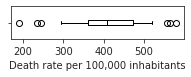

In [10]:
fig, ax = plt.subplots(figsize=(util.centimeter_to_inch(7), util.centimeter_to_inch(3)))

boxprops = dict(color='black')
medianprops = dict(color='black')

plt.boxplot(df_final['TAXA_OBITOS'], vert=False, whis=0.70, labels=[''], boxprops=boxprops, medianprops=medianprops)
plt.xlabel('Death rate per 100,000 inhabitants')

plt.tight_layout()

plt.savefig('../images/boxplot_death_rate.pdf', bbox_inches="tight")
plt.show()

## Figure 2 - Pandemic data overview

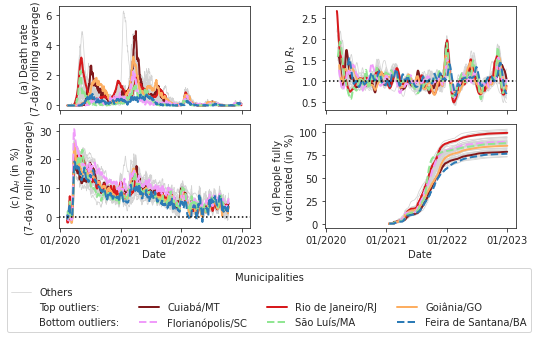

In [11]:
#============== General sets ==========================
fig, ax = plt.subplots(2, 2, figsize=(util.centimeter_to_inch(19.05), util.centimeter_to_inch(9.69)), sharex=True)

ax_0 = ax.flatten()[0]
ax_1 = ax.flatten()[1]
ax_2 = ax.flatten()[2]
ax_3 = ax.flatten()[3]

palette = util.get_default_colors_divergence_seaborn_set_2(6, reverse=True)

#============== Chart 0 - Death ==========================
legend = 'brief'
label = 'Others'
for municipality in df[~df['MUNICIPIO_UF'].isin(list_top_3_outliers + list_bottom_3_outliers)]['MUNICIPIO_UF'].unique():        
    municipality_data = df[df['MUNICIPIO_UF'] == municipality]
    sns.lineplot(data=municipality_data, x='DATA', y='TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', color='lightgray', legend=legend, label=label, linewidth=0.75, ax=ax_0)
    legend = False
    label = None
         
for i, municipality in enumerate((list_top_3_outliers + list_bottom_3_outliers[::-1])): 
    municipality_data = df[df['MUNICIPIO_UF'] == municipality]
    if municipality in list_top_3_outliers:
        line_style = '-'
    else:
        line_style = '--'
    sns.lineplot(data=municipality_data, x='DATA', y='TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', color=palette[i] , legend='brief', label=municipality, linewidth=2, linestyle=line_style, ax=ax_0)
    
ax_0.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax_0.set_ylabel('(a) Death rate\n(7-day rolling average)')    

#============== Chart 1 - Rt ==========================
legend = 'brief'
label = 'Others'
for municipality in df[~df['MUNICIPIO_UF'].isin(list_top_3_outliers + list_bottom_3_outliers)]['MUNICIPIO_UF'].unique():        
    municipality_data = df[df['MUNICIPIO_UF'] == municipality]
    sns.lineplot(data=municipality_data, x='DATA', y='NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA', color='lightgray', legend=legend, label=label, linewidth=0.75, ax=ax_1)     
    legend = False
    label = None
     
for i, municipality in enumerate((list_top_3_outliers + list_bottom_3_outliers[::-1])): 
    municipality_data = df[df['MUNICIPIO_UF'] == municipality]
    if municipality in list_top_3_outliers:
        line_style = '-'
    else:
        line_style = '--'
    sns.lineplot(data=municipality_data, x='DATA', y='NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA', color=palette[i] , legend='brief', label=municipality, linewidth=2, linestyle=line_style, ax=ax_1)        

ax_1.axhline(1, 0, 1, linestyle=':', color='black')

ax_1.set_ylabel('(b) $R_{t}$')

#============== Chart 2 - Mobility ==========================
legend = 'brief'
label = 'Others'
for municipality in df_chart_mobility[~df_chart_mobility['MUNICIPIO_UF'].isin(list_top_3_outliers + list_bottom_3_outliers)]['MUNICIPIO_UF'].unique():        
    municipality_data = df_chart_mobility[df_chart_mobility['MUNICIPIO_UF'] == municipality]
    sns.lineplot(data=municipality_data, x='DATA', y='PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS_MEDIA_7_DIAS', color='lightgray', legend=legend, label=label, linewidth=0.75, ax=ax_2)     
    legend = False
    label = None
     
for i, municipality in enumerate((list_top_3_outliers + list_bottom_3_outliers[::-1])): 
    municipality_data = df_chart_mobility[df_chart_mobility['MUNICIPIO_UF'] == municipality]
    if municipality in list_top_3_outliers:
        line_style = '-'
    else:
        line_style = '--'
    sns.lineplot(data=municipality_data, x='DATA', y='PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS_MEDIA_7_DIAS', color=palette[i] , legend='brief', label=municipality, linewidth=2, linestyle=line_style, ax=ax_2)        
    
ax_2.axhline(0, 0, 1, linestyle=':', color='black')
ax_2.set_ylabel('(c) $\Delta_{H}$ (in %)\n(7-day rolling average)')

ax_2.xaxis.set_major_formatter(myFmt)
ax_2.set_xlabel('Date')
ax_2.set_xticks(desired_dates)
   
#============== Chart 3 - Vaccination ==========================   
legend = 'brief'
label = 'Others'
for municipality in df_chart_vaccination[~df_chart_vaccination['city'].isin(list_top_3_outliers + list_bottom_3_outliers)]['city'].unique():        
    municipality_data = df_chart_vaccination[df_chart_vaccination['city'] == municipality]
    sns.lineplot(data=municipality_data, x='date', y='percentual_people_fully_vaccinated', color='lightgray', legend=legend, label=label, linewidth=0.75, ax=ax_3)
    legend = False
    label = None
         
for i, municipality in enumerate((list_top_3_outliers + list_bottom_3_outliers[::-1])): 
    municipality_data = df_chart_vaccination[df_chart_vaccination['city'] == municipality]
    if municipality in list_top_3_outliers:
        line_style = '-'
    else:
        line_style = '--'
    sns.lineplot(data=municipality_data, x='date', y='percentual_people_fully_vaccinated', color=palette[i] , legend='brief', label=municipality, linewidth=2, linestyle=line_style, ax=ax_3)        

# Creating custom legend entries and labels
legend_elements = [
    mlines.Line2D([], [], color='black', linestyle='', label='Top outliers'),
    mlines.Line2D([], [], color='black', linestyle='', label='Bottom outliers')
]

ax_3.set_ylabel('(d) People fully\nvaccinated (in %)')
ax_3.xaxis.set_major_formatter(myFmt)
ax_3.set_xlabel('Date')
ax_3.set_xticks(desired_dates)

#============== General sets ==========================
# Creating custom legend entries and labels
legend_top_outliers = mlines.Line2D([], [], color='black', linestyle='', label='Top outliers:')
legend_bottom_outliers = mlines.Line2D([], [], color='black', linestyle='', label='Bottom outliers:')
legend_empty = mlines.Line2D([], [], color='black', linestyle='', label='')

# Getting the handles and labels from the plot
handles_0, labels_0 = ax_0.get_legend_handles_labels()
handles_1, labels_1 = ax_1.get_legend_handles_labels()
handles_2, labels_2 = ax_2.get_legend_handles_labels()
handles_3, labels_3 = ax_3.get_legend_handles_labels()

handles = ([handles_0[0], legend_top_outliers, legend_bottom_outliers] +
           [legend_empty, handles_1[1], handles_1[4]] +
           [legend_empty, handles_1[2], handles_1[5]] +
           [legend_empty, handles_1[3], handles_1[6]])
labels = ([labels_0[0], 'Top outliers:', 'Bottom outliers:'] +
           ['', labels_1[1], labels_1[4]] +
           ['', labels_1[2], labels_1[5]] +
           ['', labels_1[3], labels_1[6]])

# Combining the legend elements with the existing handles and labels
fig.legend(handles=handles, labels=labels,loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.025), title='Municipalities')
ax_0.legend([], frameon=False)
ax_1.legend([], frameon=False)
ax_2.legend([], frameon=False)
ax_3.legend([], frameon=False)
   
plt.tight_layout()
plt.savefig('../images/data_overview.pdf', bbox_inches="tight")
plt.show()

## Figure 3 - Monthly relative frequency (\%) of different coronavirus variants over time in Brazil

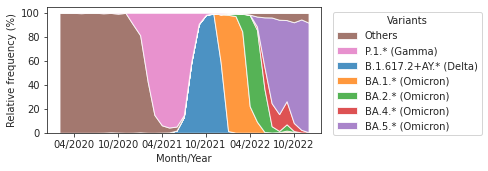

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(util.centimeter_to_inch(17.6), util.centimeter_to_inch(6.3)))

variants = df_pivoted.columns[1:]
plt.stackplot(df_pivoted['Período'], [df_pivoted[var] for var in variants], labels=variants, alpha=0.8)

plt.xlabel('Date')
plt.ylabel('Relative frequency (%)')

handles, labels = ax.get_legend_handles_labels()

# plt.legend(title='Variants', loc='upper left', bbox_to_anchor=(1, 1))  
ax.legend(handles=[handles[5],handles[6],handles[0]]+handles[1:5], labels=[labels[5],labels[6],labels[0]]+labels[1:5], title='Variants', loc='upper left', bbox_to_anchor=(1.025, 1))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month/Year')

plt.tight_layout()

plt.savefig('../images/national_variants_fiocruz.pdf', bbox_inches="tight")

plt.show()

## Figure 4 - Comprehensive analysis of simulation results for Cuiabá/MT

Cuiabá


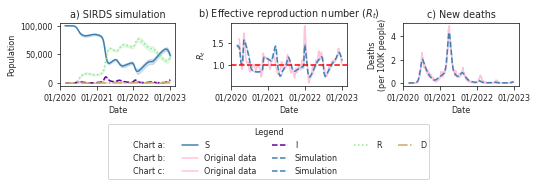

In [13]:
days_to_recovery = 8
for municipality in df_results_municipalites[(df_results_municipalites.municipality == 'Cuiabá')].municipality.unique():
    print(municipality)
    df_results = df_results_municipalites[df_results_municipalites.municipality == municipality]
    date_first_case = pd.to_datetime(df_results.date_first_case.unique()[0])
    
    df_covid_municipality = df[(df.MUNICIPIO == municipality) & (df.DATA >= date_first_case)]
    real_reproduction_number = df_covid_municipality.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA.values
    real_new_deaths = df_covid_municipality.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS.values
    real_total_deaths = df_covid_municipality.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS.cumsum().values
    real_new_cases = df_covid_municipality.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS.values
    real_total_cases = df_covid_municipality.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS.cumsum().values
        
    df_S = pd.DataFrame()
    df_I = pd.DataFrame()
    df_R = pd.DataFrame()
    df_D = pd.DataFrame()
    df_I_accumulated = pd.DataFrame()
    df_new_deaths = pd.DataFrame()
    df_rt = pd.DataFrame()
    df_new_cases = pd.DataFrame()
    df_r0 = pd.DataFrame()
    df_IFR = pd.DataFrame()
    df_Omega = pd.DataFrame()
    list_fuzzy_fast_transition = []
    list_fuzzy_slow_transition = []
    
    dict_performance = {'mae_fit': [], 'sse_D_fit': [], 'r2_D_fit': [], 'sse_Rt_fit': [], 'r2_Rt_fit': []}
    
    for index, result in df_results.iterrows():            
        result = result.dropna()
        
        y = get_sirds(result)
        S, I, R, D, I_accumulated = y
        min_length = min(len(real_new_deaths), len(D))
        S = S[:min_length]
        I = I[:min_length]
        R = R[:min_length]
        D = D[:min_length]
        I_accumulated = I_accumulated[:min_length]
        N = S[0] + I[0] + R[0] + D[0]
        
        dates = df_covid_municipality[:min_length].DATA.values
        
        D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated)
        
        df_S_temp = pd.DataFrame({'date': dates, 'S': S})
        df_I_temp = pd.DataFrame({'date': dates, 'I': I})
        df_R_temp = pd.DataFrame({'date': dates, 'R': R})
        df_D_temp = pd.DataFrame({'date': dates, 'D': D})
        df_I_accumulated_temp = pd.DataFrame({'date': dates, 'I_accumulated': I_accumulated})
        df_new_deaths_temp = pd.DataFrame({'date': dates[1:], 'deaths': D_new_deaths})
        df_rt_temp = pd.DataFrame({'date': dates, 'rt': reproduction_number_sird})
        df_new_cases_temp = pd.DataFrame({'date': dates[1:], 'cases': I_new_cases})
        df_r0_temp = pd.DataFrame({'date': dates, 'r0': days_to_recovery/estimated_days_between_infections}) 
        df_IRF_temp = pd.DataFrame({'date': dates, 'ifr': estimated_case_fatality_probability})
        df_Omega_temp = pd.DataFrame({'date': dates, 'Omega': estimated_loss_immunity_in_days})
                   
        df_S = pd.concat([df_S, df_S_temp])
        df_I = pd.concat([df_I, df_I_temp])
        df_R = pd.concat([df_R, df_R_temp])
        df_D = pd.concat([df_D, df_D_temp])
        df_I_accumulated = pd.concat([df_I_accumulated, df_I_accumulated_temp])
        df_new_deaths = pd.concat([df_new_deaths, df_new_deaths_temp])
        df_rt = pd.concat([df_rt, df_rt_temp])
        df_new_cases = pd.concat([df_new_cases, df_new_cases_temp])
        df_r0 = pd.concat([df_r0, df_r0_temp])
        df_IFR = pd.concat([df_IFR, df_IRF_temp])
        df_Omega = pd.concat([df_Omega, df_Omega_temp])
        list_fuzzy_fast_transition.append(epidemic_periods_with_fast_transition_fuzzy_variable)
        list_fuzzy_slow_transition.append(epidemic_periods_with_slow_transition_fuzzy_variable)

    plot_result_simple(df_S, df_I, df_R, df_D, df_new_deaths, df_I_accumulated, real_new_deaths[:min_length], real_total_deaths[:min_length], real_reproduction_number[:min_length], df_rt, real_total_cases[:min_length], real_new_cases[:min_length], df_new_cases, df_covid_municipality[:min_length].DATA.values, id_in_file=municipality)

## Figure 5 - Model parameters varying by time ($t$) estimated for COVID-19

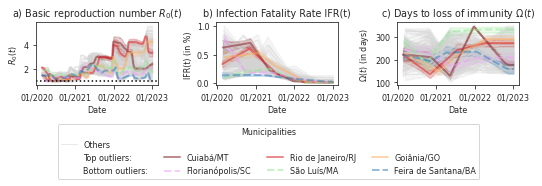

In [14]:
df_general = df_general.sort_values(by=['MUNICIPIO_UF','date'])

fig, ax = plt.subplots(1, 3, figsize=(util.centimeter_to_inch(19.05), util.centimeter_to_inch(4.42)))

legend = 'brief'
label = 'Others'
for municipality in df_general[~df_general['MUNICIPIO_UF'].isin(list_top_3_outliers+list_bottom_3_outliers)]['MUNICIPIO_UF'].unique():
    df_municipality = df_general[df_general['MUNICIPIO_UF'] == municipality]
    
    # df_municipality = df_municipality[df_municipality['date']>=pd.to_datetime('2022-12-21')]    
    
    sns.lineplot(x=df_municipality['date'], y=df_municipality['r0'], markers=False, color='lightgray', errorbar=('ci', 95), alpha=0.5, ax=ax[0], legend=legend, label=label, linewidth=1)  
    sns.lineplot(x=df_municipality['date'], y=df_municipality['ifr']*100, markers=False, color='lightgray', errorbar=('ci', 95), alpha=0.5, ax=ax[1], legend=legend, label=label, linewidth=1)
    sns.lineplot(x=df_municipality['date'], y=df_municipality['Omega'], markers=False, color='lightgray',
                 errorbar=('ci', 95), alpha=0.5, ax=ax[2], legend=legend, label=label, linewidth=1)
    legend = False
    label = None
    
palette = util.get_default_colors_divergence_seaborn_set_2(6, reverse=True)

for i, municipality in enumerate((list_top_3_outliers + list_bottom_3_outliers[::-1])): 
    df_municipality = df_general[df_general['MUNICIPIO_UF'] == municipality]
    
    # df_municipality = df_municipality[df_municipality['date']>=pd.to_datetime('2022-12-21')]
    
    if municipality in list_top_3_outliers:
        line_style = '-'
    else:
        line_style = '--'
    
    sns.lineplot(x=df_municipality['date'], y=df_municipality['r0'], markers=False, color=palette[i], errorbar=('ci', 95), alpha=0.5, ax=ax[0], legend='brief', label=municipality, linewidth=2, linestyle=line_style)  
    sns.lineplot(x=df_municipality['date'], y=df_municipality['ifr']*100, markers=False, color=palette[i], errorbar=('ci', 95), alpha=0.5, ax=ax[1], legend='brief', label=municipality, linewidth=2, linestyle=line_style)
    sns.lineplot(x=df_municipality['date'], y=df_municipality['Omega'], markers=False, color=palette[i],
                 errorbar=('ci', 95), alpha=0.5, ax=ax[2], legend='brief', label=municipality, linewidth=2, linestyle=line_style)
    
# Plot fuzzy R0
ax[0].set_ylabel("$R_{0}(t)$")
ax[0].set_xticks(desired_dates)
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_xlabel('Date')
ax[0].tick_params(axis='x', rotation=0)
ax[0].set_title('a) Basic reproduction number $R_{0}(t)$')
ax[0].axhline(1, 0, 1, linestyle=':', color='black')

# Plot fuzzy IFR
ax[1].set_ylabel("IFR(t) (in %)")
ax[1].set_xticks(desired_dates)
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', rotation=0)
ax[1].set_title('b) Infection Fatality Rate IFR(t)')

# Plot fuzzy days to loss the immunity
ax[2].set_ylabel("$\Omega(t)$ (in days)")
ax[2].set_xticks(desired_dates)
ax[2].xaxis.set_major_formatter(myFmt)
ax[2].set_xlabel('Date')
ax[2].tick_params(axis='x', rotation=0)
ax[2].set_title('c) Days to loss of immunity $\Omega(t)$')

# Creating custom legend entries and labels
legend_top_outliers = mlines.Line2D([], [], color='black', linestyle='', label='Top outliers:')
legend_bottom_outliers = mlines.Line2D([], [], color='black', linestyle='', label='Bottom outliers:')
legend_empty = mlines.Line2D([], [], color='black', linestyle='', label='')

# Getting the handles and labels from the plot
handles_0, labels_0 = ax[0].get_legend_handles_labels()
handles_1, labels_1 = ax[1].get_legend_handles_labels()
handles_2, labels_2 = ax[2].get_legend_handles_labels()

handles = ([handles_0[0], legend_top_outliers, legend_bottom_outliers] +
           [legend_empty, handles_1[1], handles_1[4]] +
           [legend_empty, handles_1[2], handles_1[5]] +
           [legend_empty, handles_1[3], handles_1[6]])
labels = ([labels_0[0], 'Top outliers:', 'Bottom outliers:'] +
           ['', labels_1[1], labels_1[4]] +
           ['', labels_1[2], labels_1[5]] +
           ['', labels_1[3], labels_1[6]])

# Combining the legend elements with the existing handles and labels
fig.legend(handles=handles, labels=labels,loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.025), title='Municipalities')
ax[0].legend([], frameon=False)
ax[1].legend([], frameon=False)
ax[2].legend([], frameon=False)

fig.tight_layout()

filename = '../images/result_parameters_general'
plt.savefig(filename+'.pdf', bbox_inches="tight")

plt.show()